Tesseract Overview
-----------------------

This notebook is supposed to provide a brief overview over the Tesseract framework (and might be later adapted to Transcend as well).


    ├── tesseract             <- Main folder
    │   ├── mock.py           <- Module for generating test distributions for use with Tesseract
    │   ├── evaluation.py     <- This is the class where the magic happens  ;)
    │   ├── metrics.py        <- Various methods to calculate and output metrics (including AUT)
    │   └── ...

**TODO**: Extend this description

## Running this Notebook 

1. Run `make data` to pull the necessary data files. 
2. Reproduce Drebin graph from paper (Figure 5)

---

In [1]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [29]:
from tesseract import evaluation, temporal, metrics, mock

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [ ]:
from sklearn.svm import LinearSVC

# Perform a timeline evaluation
clf = LinearSVC()
results_10 = evaluation.fit_predict_update(clf, *splits)
    
# View results 
metrics.print_metrics(results_10)

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
24it [00:11,  2.03it/s]

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

In [42]:
print(f"Robustness over time (measured in AUT): {metrics.aut(results_10, 'f1')}")

Robustness over time (measured in AUT): 0.5765016554216945


F1 AUT: 0.5765016554216945
Recall AUT: 0.47799905859644776
Precision AUT: 0.7553576222129668


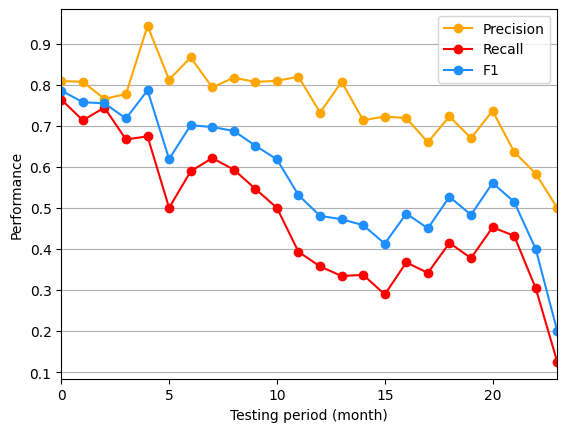

In [32]:
print(f"F1 AUT: {metrics.aut(results_10, 'f1')}")
print(f"Recall AUT: {metrics.aut(results_10, 'recall')}")
print(f"Precision AUT: {metrics.aut(results_10, 'precision')}")
#%%
from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

'#FF9999', '#FFDD99', '#AAEEEE'
plot(results_10['precision'], marker='o', color=pendleyellow)
plot(results_10['recall'], marker='o', color='red')
plot(results_10['f1'], marker='o', color=pendleblue)
legend(['Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')

### Reproducing Figure 6

In [46]:
# Finding the optimal malware ratio in training data
from tesseract import spatial 
# extract splits because we'll need to access X, y and temp individually to find the # optimal malware percentage
X_train, X_test, y_train, y_test, temp_train, temp_test = splits

Figure out the accuracy of the classifier with 10% malware in the training data. We need the accuracy to set the acceptable error rate to 1 - accuracy for optimising for the F1-Score. 

In [47]:
tp_list = results_10['tp']
tn_list = results_10['tn']
fp_list = results_10['fp']
fn_list = results_10['fn']

# Sum the lists
total_tp = sum(tp_list)
total_tn = sum(tn_list)
total_fp = sum(fp_list)
total_fn = sum(fn_list)

# Calculate accuracy
accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
print(f"Overall Accuracy: {accuracy}")

Overall Accuracy: 0.9331694171250764


Run the `find_optimal_train_ratio()` function to find the optimal training ratio. According to the Tesseract paper, they did this using 8 months of training data and 4 months (split into chunks of 1 month) testing data.

`X_train` and `y_train` contain the apps for a year, since when we ran the `time_aware_train_test_split`, we set the parameter of `train_size` to 12 with a granularity of `months`.

In [50]:
spatial_clf = LinearSVC()
optimal_malware_training_ratio, aut, error_rate = spatial.find_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`, taken from X_train, which has 12 months in total
    validation_size=1, # the remaining 4 months, validate 4 times with a validation window of 1 month
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    acceptable_errors=0.1,
    end_tr_rate=0.5 # Stop at max 50% malware
)
print(f"Optimal malware training ratio: {optimal_malware_training_ratio}")

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:07,  1.90s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:04,  1.02s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:02,  1.38it/s]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1

Optimal malware training ratio: 0.15000000000000002


In [48]:
spatial_clf = LinearSVC()
rates = spatial.search_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=1, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    end_tr_rate=0.5 # Stop at max 50% malware
)

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:06,  1.63s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:04,  1.14s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:03,  1.02it/s]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1

In [49]:
import pandas as pd 

rates = pd.DataFrame(rates)
rates

,errors,auts,phis,fn,fp,total
0,0.030958,0.792954,0.10,280.0,154.0,14019.0
1,0.031671,0.799286,0.15,236.0,208.0,14019.0
2,0.032313,0.791152,0.20,233.0,220.0,14019.0
3,0.032741,0.790583,0.25,232.0,227.0,14019.0
4,0.034239,0.788569,0.30,211.0,269.0,14019.0
5,0.037235,0.776554,0.35,225.0,297.0,14019.0
6,0.041800,0.761911,0.40,189.0,397.0,14019.0
7,0.043655,0.752907,0.45,187.0,425.0,14019.0
8,0.043298,0.766169,0.50,166.0,441.0,14019.0


Okay, now we figured out that the AUT score is the highest with a malware percentage of 25%. So we can retrain our classifier with 25% of malware in the training data. 

In [38]:
# Redo splitting
X_train, X_test, y_train, y_test, temp_train, temp_test = temporal.time_aware_train_test_split(X, y, t, train_size=8, test_size=1, granularity='month')

# Downsample so that there's 25% malware in the training data
train_idxs = spatial.downsample_to_rate(y_train, 0.25)

X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
temp_train = temp_train[train_idxs]

In [39]:
# Train a new classifier 
clf = LinearSVC() 
results_25 = evaluation.fit_predict_update(clf, X_train, X_test, y_train, y_test, temp_train, temp_test)

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
28it [00:03,  7.14it/s]


In [51]:
metrics.print_metrics(results_25)

------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28   
------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    399    591    145    147    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   4176   6345   1305   1444   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   40

In [53]:
print(f"New robustness over time (measured in AUT): {metrics.aut(results_10, 'f1')}")

New robustness over time (measured in AUT): 0.5765016554216945


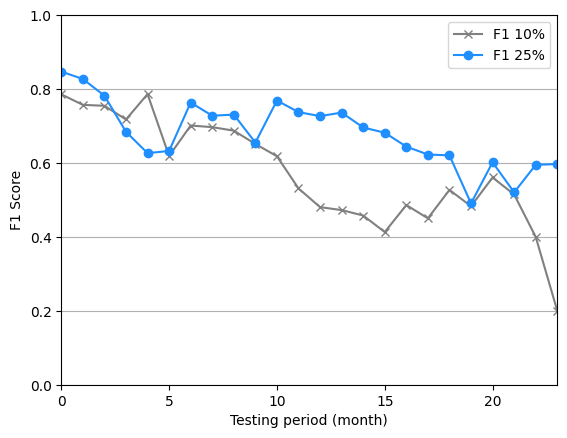

In [41]:
# Reproduce the plot 

plot(results_10['f1'], marker='x', color='gray')
plot(results_25['f1'], marker='o', color=pendleblue)
legend(['F1 10%', 'F1 25%'])
xlim([0, 23])
ylim([0, 1])
xlabel('Testing period (month)')
ylabel('F1 Score')
grid(axis = 'y')